In [1]:
import pygplates
import pandas
import pygmt
import numpy as np
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions, Rocks

%load_ext autoreload
%autoreload 2

In [2]:
P2015 = Reconstructions.fetch_Pehrsson2015()

random_points = PointDistributionOnSphere(N=2000)

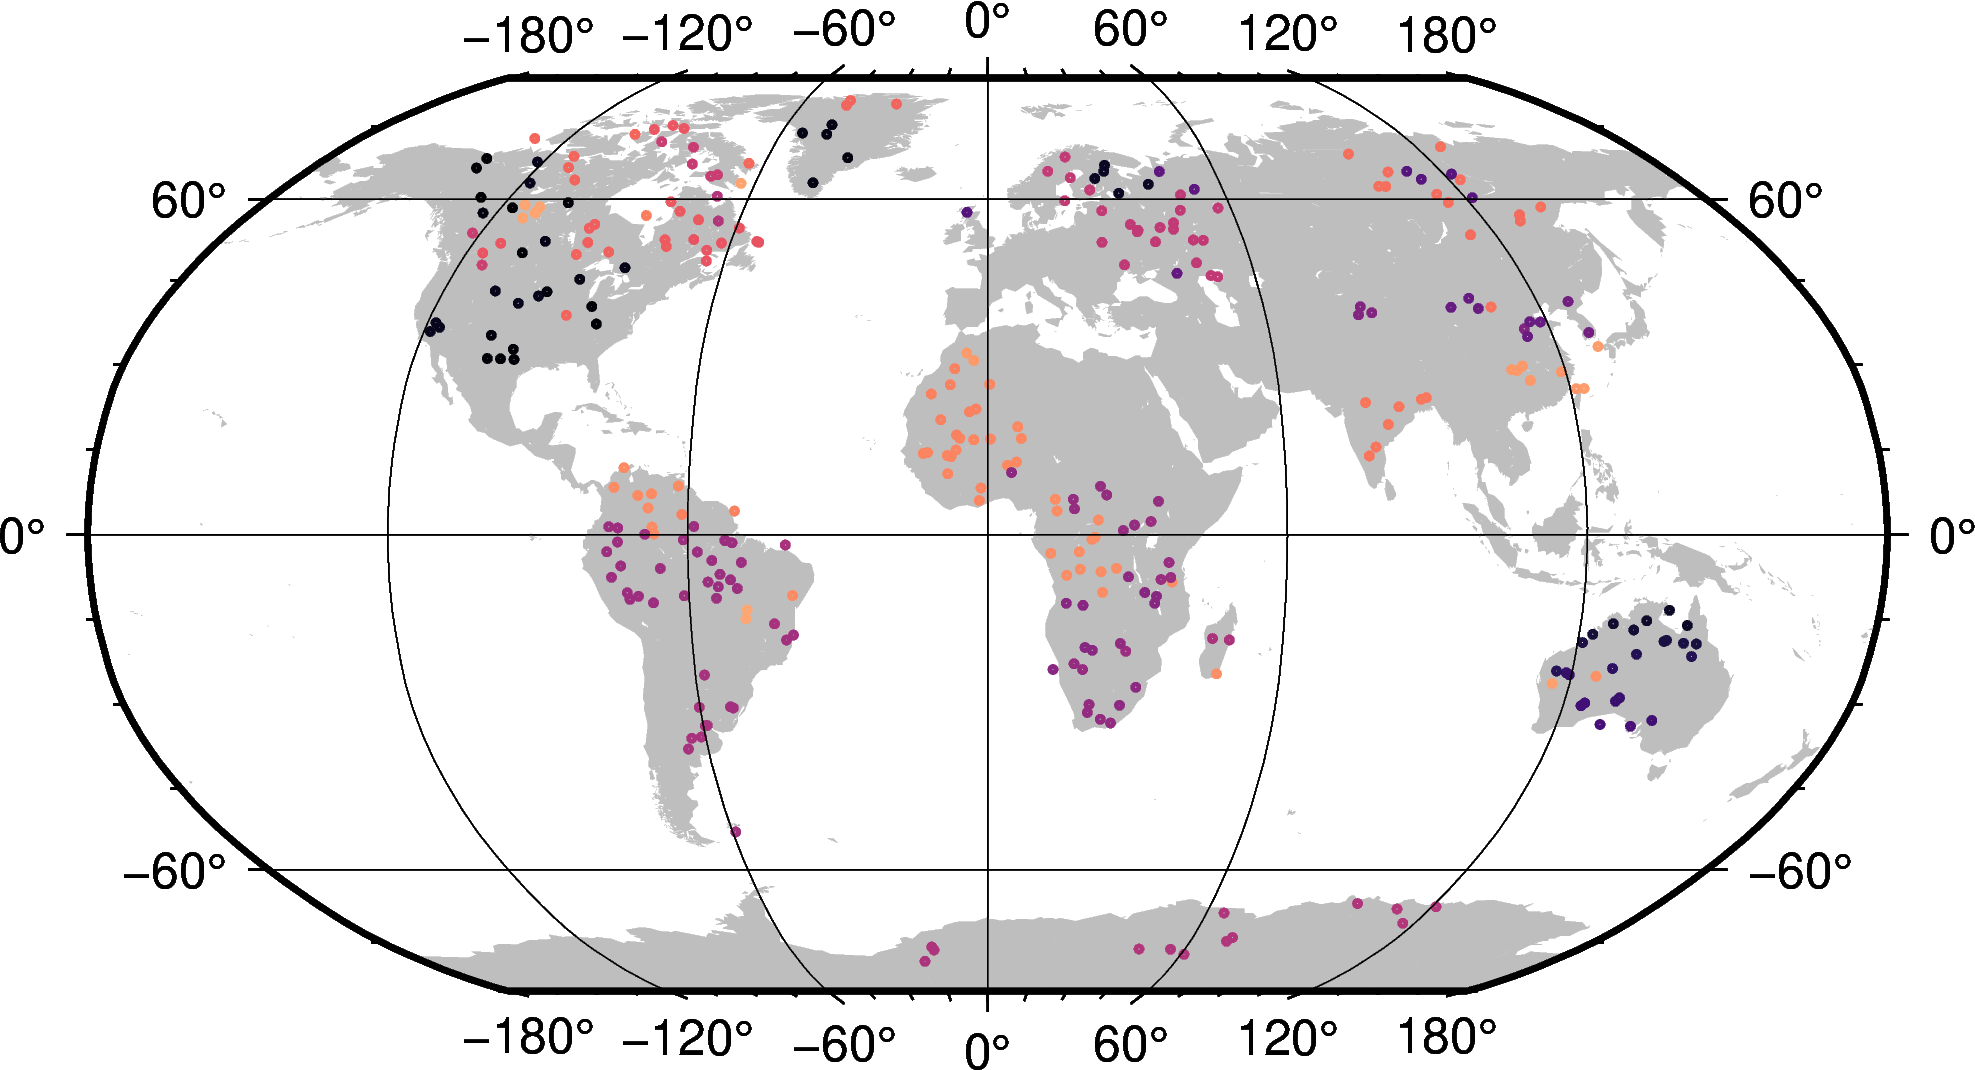

In [3]:
assigned_point_features = pygplates.partition_into_plates(
            P2015.static_polygons,
            P2015.rotation_model,
            random_points.meshnode_feature,
            properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='magma', series=[0,1000,1])
for feature in assigned_point_features:
    if feature.get_reconstruction_plate_id() != 0:
        geom = feature.get_geometry().to_lat_lon_array()
        fig.plot(x=geom[:,1], y=geom[:,0],
                 style='c0.05c', pen='1p', cmap=True, zvalue=feature.get_reconstruction_plate_id())
fig.basemap(frame='afg')

fig.show(width=900)

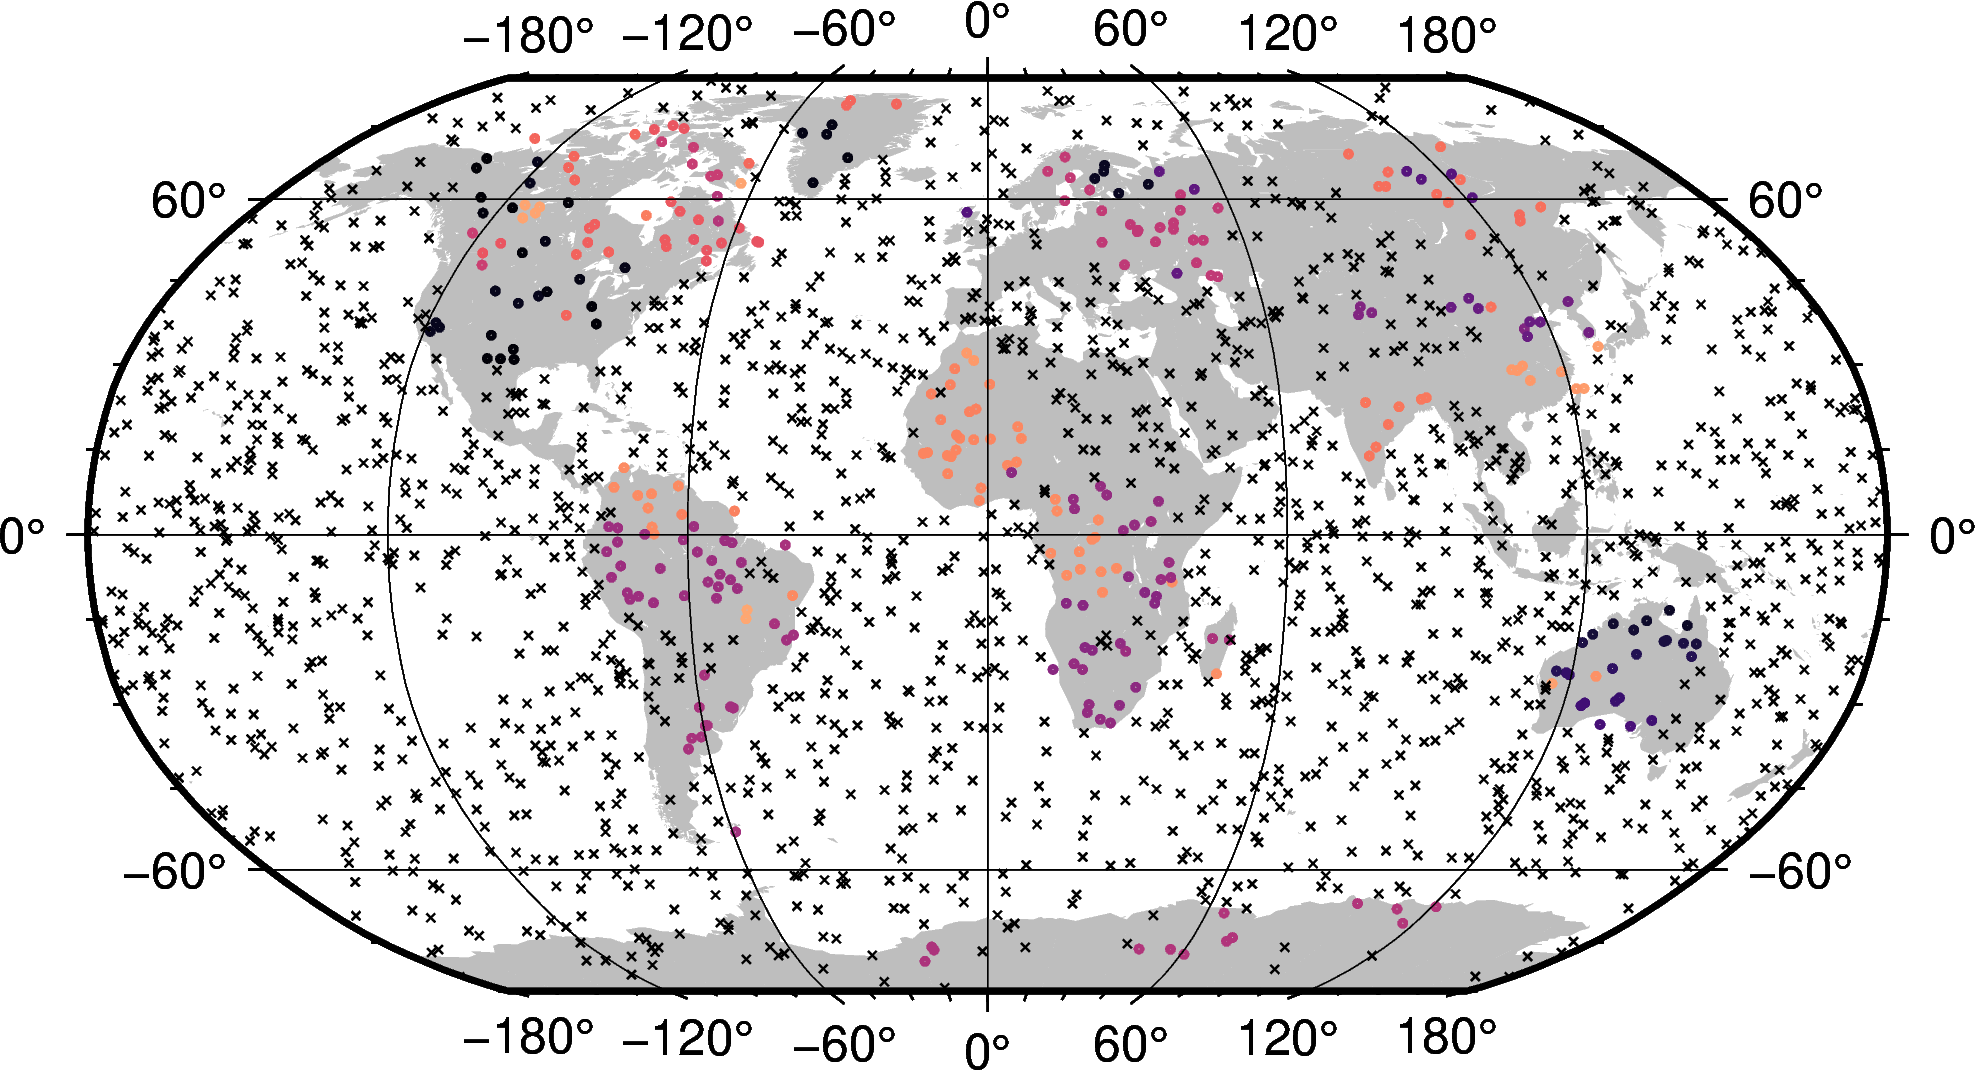

In [4]:
(assigned_point_features,
 unpartitioned_features) = pygplates.partition_into_plates(
            P2015.static_polygons,
            P2015.rotation_model,
            random_points.meshnode_feature,
            properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id],
            partition_return = pygplates.PartitionReturn.separate_partitioned_and_unpartitioned)


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='magma', series=[0,1000,1])
for feature in assigned_point_features:
    geom = feature.get_geometry().to_lat_lon_array()
    fig.plot(x=geom[:,1], y=geom[:,0],
             style='c0.05c', pen='1p', cmap=True, zvalue=feature.get_reconstruction_plate_id())
for feature in unpartitioned_features:
    geom = feature.get_geometry().to_lat_lon_array()
    fig.plot(x=geom[:,1], y=geom[:,0],
             style='x0.1c', pen='0.5p,black')  
fig.basemap(frame='afg')

fig.show(width=900)


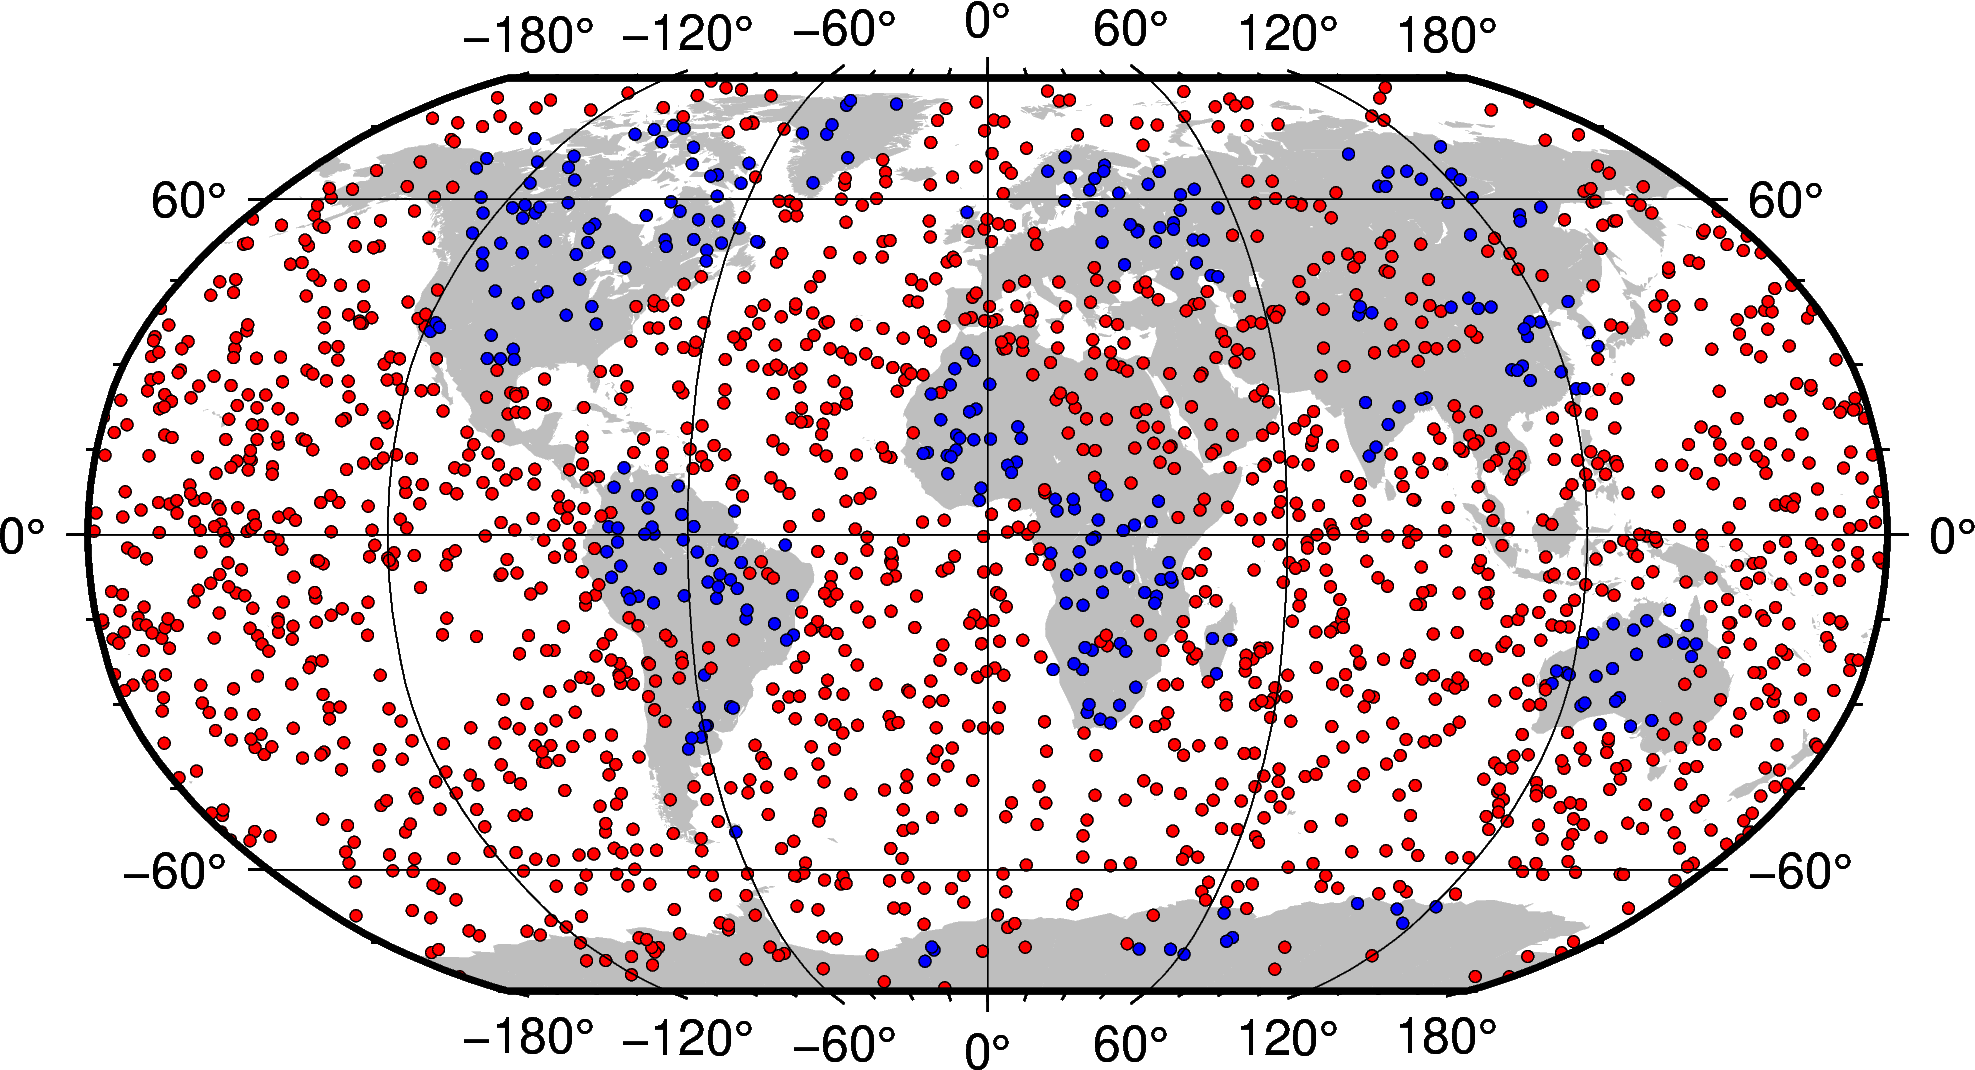

In [5]:
from ptt.utils import points_in_polygons

points = random_points.multipoint.get_points()

polygons = []
for feature in pygplates.FeatureCollection(P2015.static_polygon_files[0]):
    for polygon in feature.get_all_geometries():
        polygons.append(polygon)

polygons_containing_points = points_in_polygons.find_polygons(points, polygons)

#print(polygons_containing_points)

#'''
lat = []
lon = []
zval = []
for pcp,point in zip(polygons_containing_points,points):
    lat.append(point.to_lat_lon()[0])
    lon.append(point.to_lat_lon()[1])
    if pcp is not None:
        zval.append(1)
    else:
        zval.append(0)


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='red,blue', series=[0,1])
fig.plot(x=lon, y=lat,
         style='c0.1c', pen='0.2p', cmap=True, color=zval)

fig.basemap(frame='afg')

fig.show(width=900)

78 42


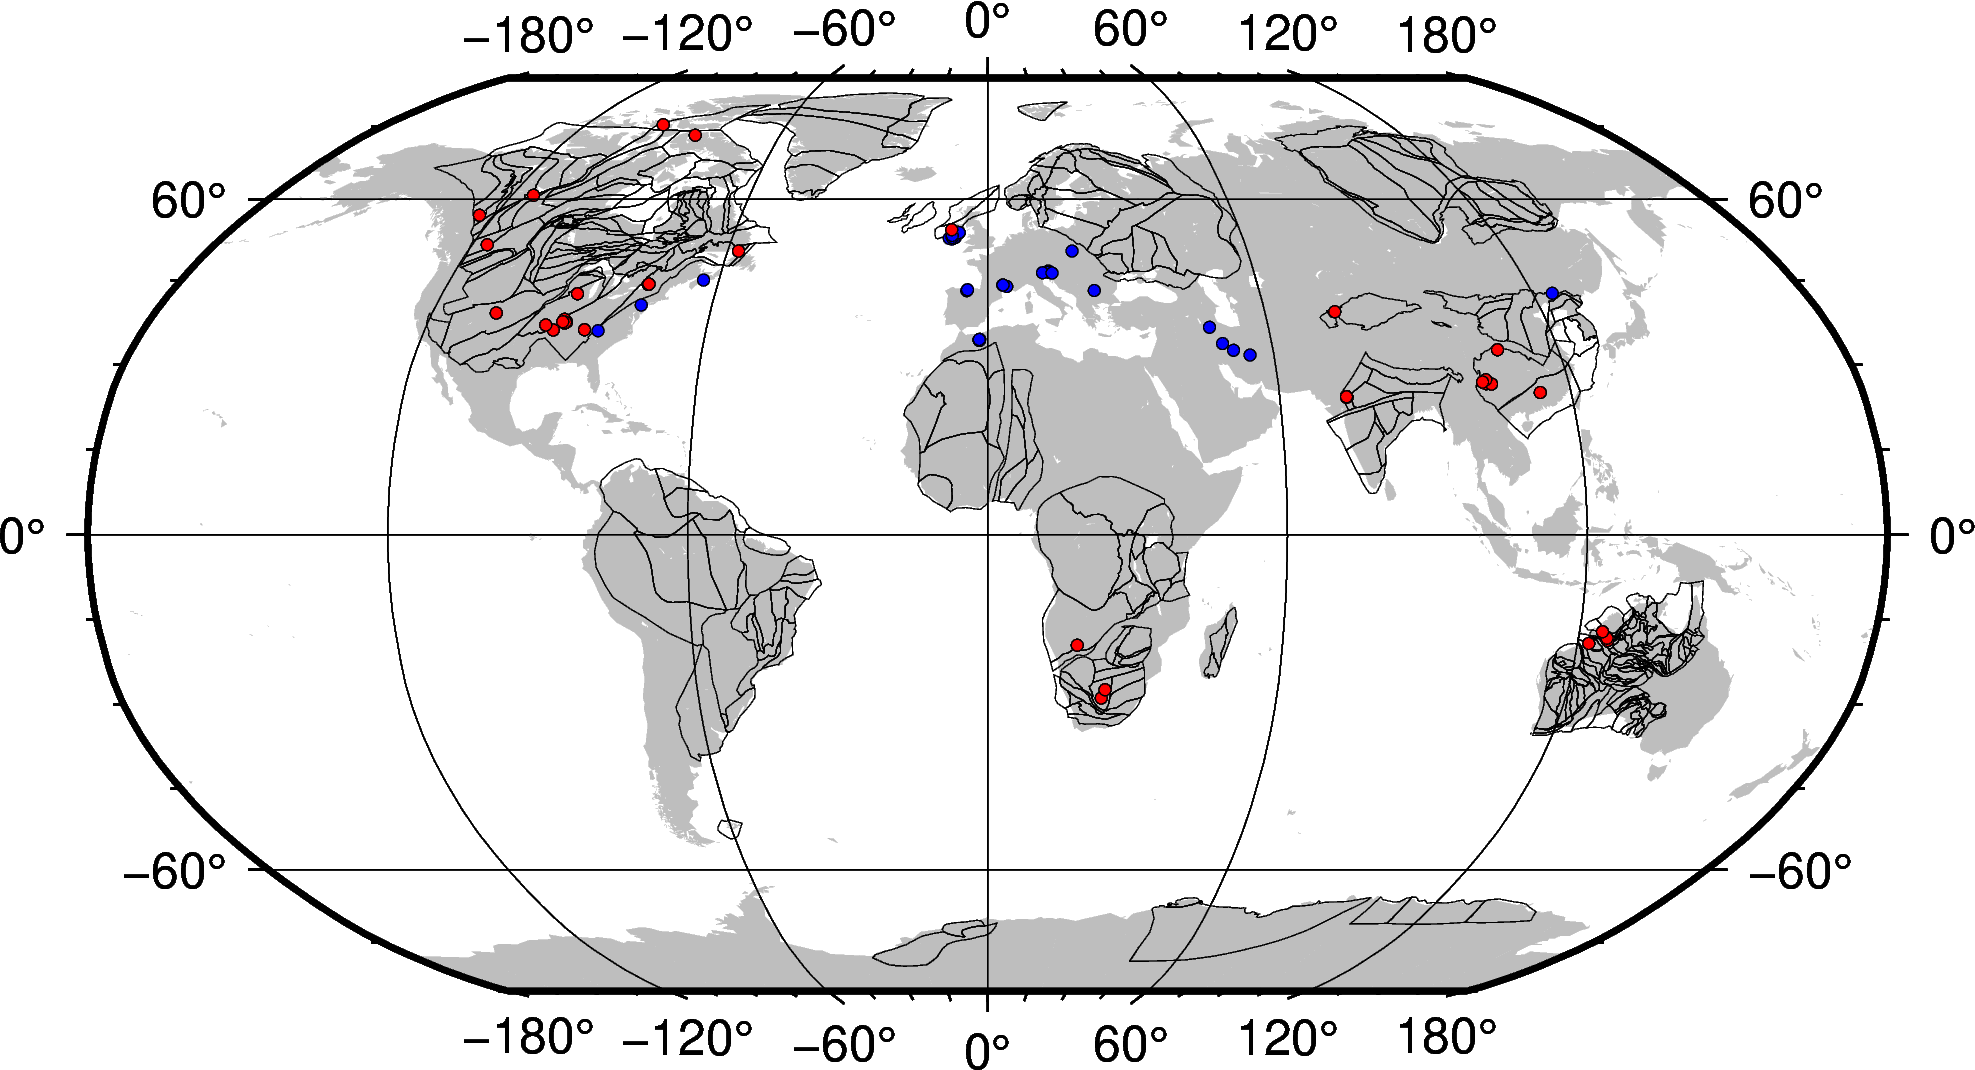

In [8]:
def cookie_cut(x, y, polygon_features):

    points = [pygplates.PointOnSphere(lat,lon) for lon,lat in zip(x,y)]

    polygons = []
    for feature in polygon_features:
        for polygon in feature.get_all_geometries():
            polygons.append(polygon)

    polygons_containing_points = points_in_polygons.find_polygons(points, polygons)

    lat = []
    lon = []
    zval = []
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.to_lat_lon()[0])
        lon.append(point.to_lat_lon()[1])
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    return zval

od = Rocks.BaseMetalDeposits('PbZn-MVT')
#od = Rocks.Geochem()


ind = cookie_cut(x=od.Longitude, y=od.Latitude, polygon_features=pygplates.FeatureCollection(P2015.static_polygon_files[0]))


odi = od.iloc[np.where(ind)]

print(len(od), len(odi))

fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='red,blue', series=[0,1])
fig.plot(data=P2015.static_polygon_files[0],
         pen='0.2p,black')
fig.plot(x=od.Longitude, y=od.Latitude,
         style='c0.1c', pen='0.2p', color='blue')
fig.plot(x=odi.Longitude, y=odi.Latitude,
         style='c0.1c', pen='0.2p', color='red')
fig.basemap(frame='afg')

fig.show(width=900)


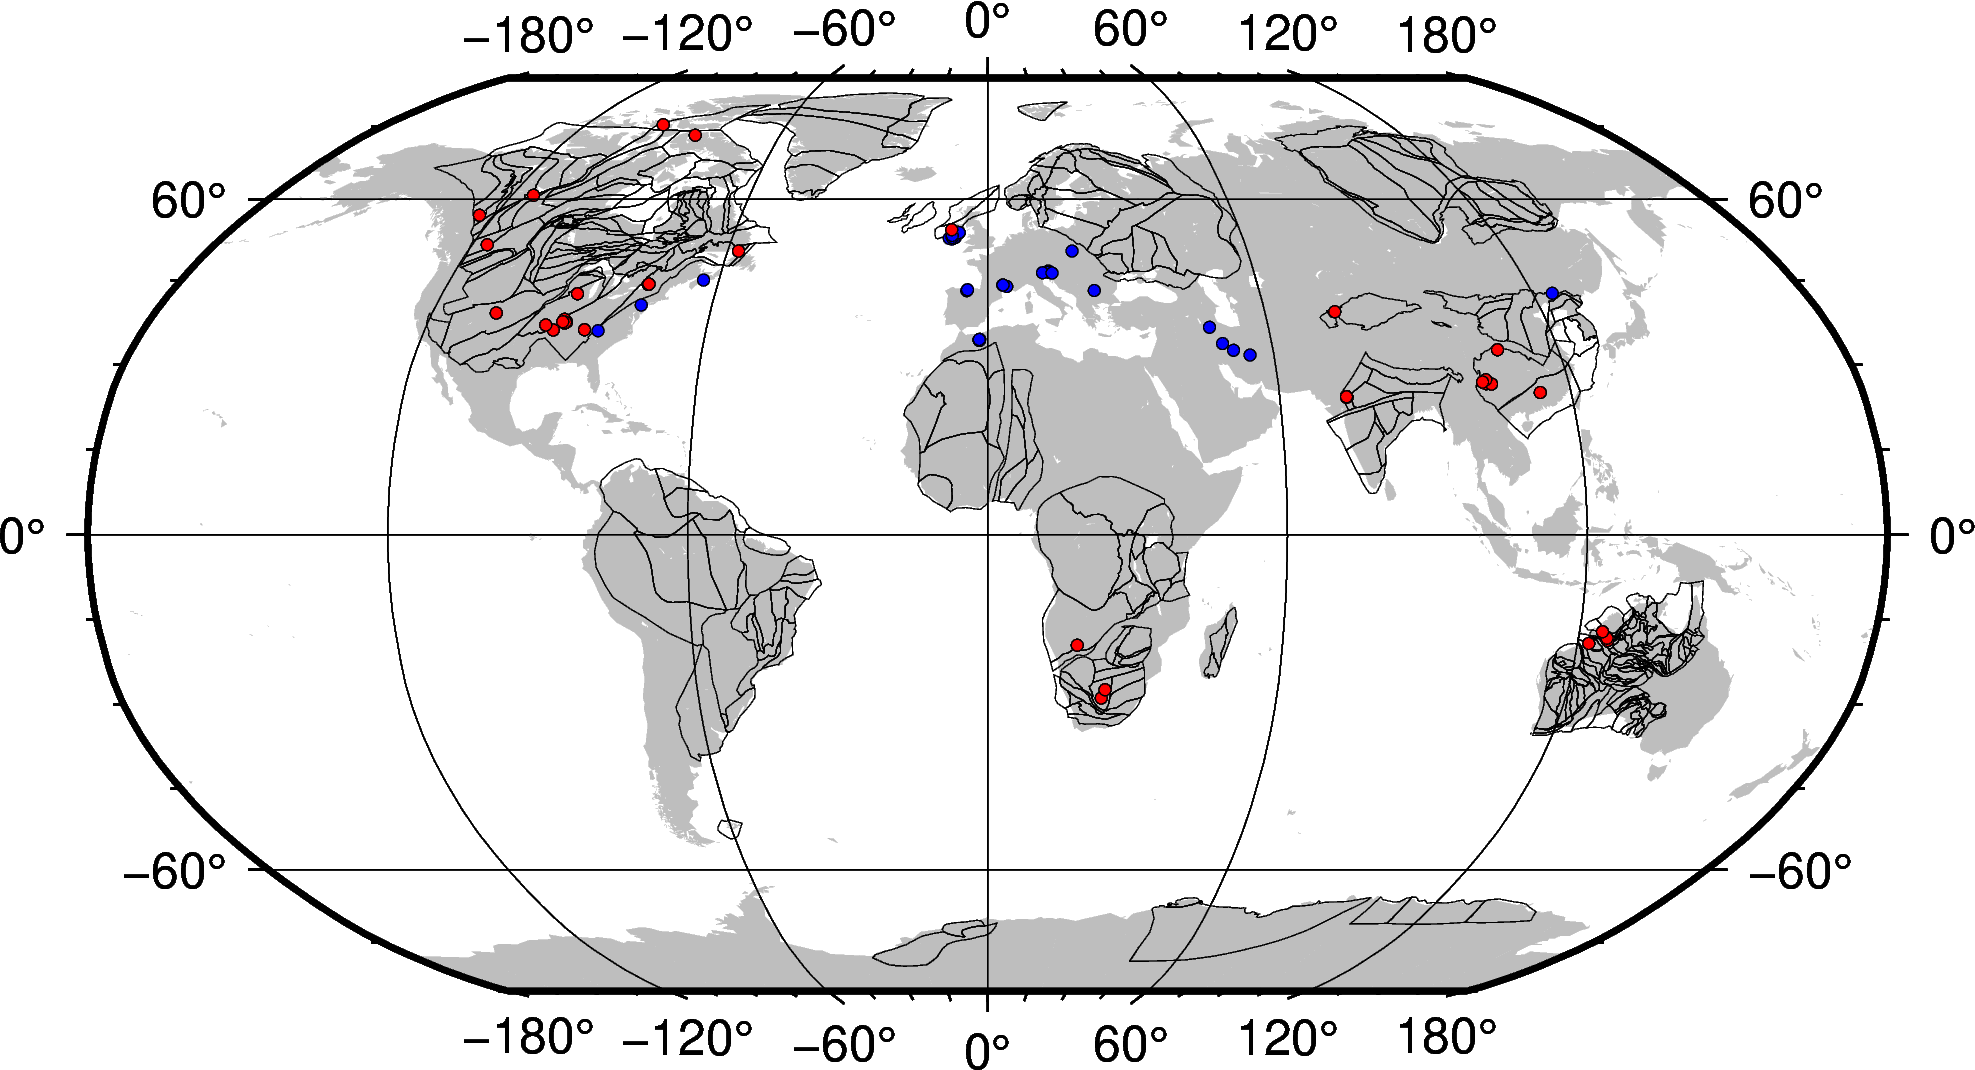

In [9]:
import geopandas as gpd

od_gdf = gpd.GeoDataFrame(od, geometry=gpd.points_from_xy(od.Longitude, od.Latitude), crs=4326)

polygon_gdf = gpd.read_file(P2015.static_polygon_files[0])

od_clip = gpd.clip(od_gdf, polygon_gdf)

fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='red,blue', series=[0,1])
fig.plot(data=P2015.static_polygon_files[0],
         pen='0.2p,black')
fig.plot(x=od.Longitude, y=od.Latitude,
         style='c0.1c', pen='0.2p', color='blue')
fig.plot(x=od_clip.Longitude, y=od_clip.Latitude,
         style='c0.1c', pen='0.2p', color='red')
fig.basemap(frame='afg')

fig.show(width=900)

In [ ]:
gc = Rocks.Geochem()

gc_gdf = gpd.GeoDataFrame(gc, geometry=gpd.points_from_xy(gc.Longitude, gc.Latitude), crs=4326)

polygon_gdf = gpd.read_file(P2015.static_polygon_files[0])

gc_clip = gpd.clip(gc_gdf, polygon_gdf)


fig = pygmt.Figure()

fig.basemap(frame='afg', region='d', projection='N6i')
fig.coast(land='grey')
pygmt.makecpt(cmap='red,blue', series=[0,1])
fig.plot(data=P2015.static_polygon_files[0],
         pen='0.2p,black')
fig.plot(x=gc_gdf.Longitude, y=gc_gdf.Latitude,
         style='c0.1c', pen='0.2p', color='blue')
fig.plot(x=gc_clip.Longitude, y=gc_clip.Latitude,
         style='c0.1c', pen='0.2p', color='red')
fig.basemap(frame='afg')

fig.show(width=900)


In [ ]:
from geopandas.tools import sjoin

join_left_df = sjoin(gc_gdf, polygon_gdf, how="left")

join_left_df

